# Projeto 1

O roteiro é mais ou menos esse:

    Sugestão de Roteiro Prático

    Realize uma análise exploratória dos dados (EDA).​

    Padronize os dados com StandardScaler.​

    Aplique PCA para reduzir a dimensionalidade e visualize os dados em 2D ou 3D.​

    Considere binarizar a variável quality para transformar o problema em uma classificação binária.​

    Treine modelos como Random Forest, SVM e XGBoost.​

    Avalie os modelos utilizando métricas apropriadas (acurácia, precisão, recall, F1-score).​

    Ajuste os hiperparâmetros utilizando técnicas como GridSearchCV.​

    Documente os resultados e conclusões.

## Imports

In [16]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## Análise dos Dados

## Leitura dos dados e gráficos iniciais

Primeiras linhas do dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8   

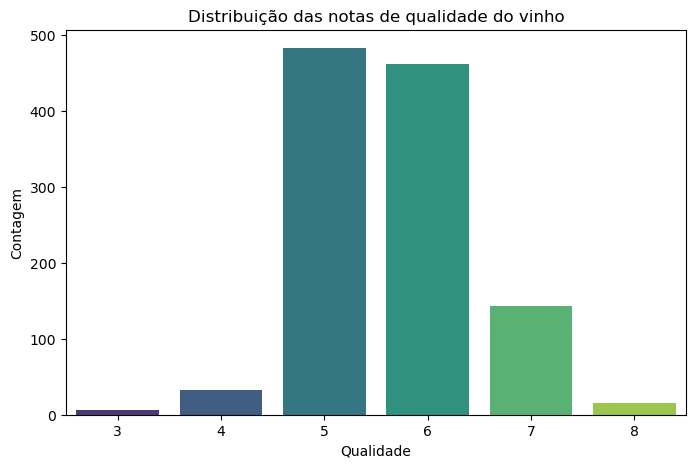

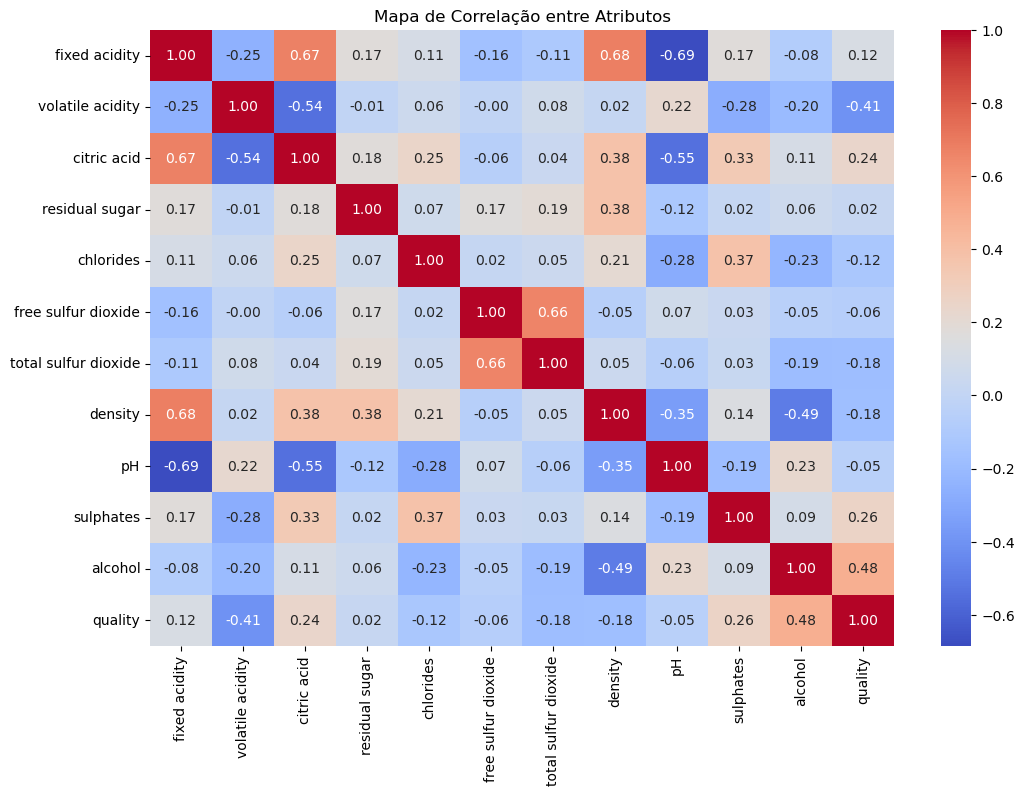

In [8]:
# 1. Definir o caminho para o arquivo CSV
path = "C:/Users/gabri/Downloads/wineQT.csv"

# 2. Carregar o dataset
# Substitua o caminho abaixo pelo caminho local do seu arquivo
df = pd.read_csv(path)

# Remove a coluna "Id" se existir
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# 3. Visualizar as primeiras linhas
print("Primeiras linhas do dataset:")
print(df.head())

# 4. Informações gerais sobre o dataset
print("\nInformações do dataset:")
print(df.info())

# 5. Estatísticas descritivas
print("\nEstatísticas descritivas:")
print(df.describe())

# 6. Verificar valores nulos
print("\nValores nulos por coluna:")
print(df.isnull().sum())

# 7. Distribuição da variável alvo (qualidade)
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Distribuição das notas de qualidade do vinho')
plt.xlabel('Qualidade')
plt.ylabel('Contagem')
plt.show()

# 8. Mapa de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação entre Atributos')
plt.show()


## Análise básica de variáveis (tipos, estatísticas e desbalanceamento)

### 1. Tipos das Variáveis:

In [ ]:
print("Tipos de Variáveis:\n")
print(df.dtypes)

Tipos de Variáveis:

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

--------------------------------------------------



É possível verificar que todas as variáveis são valores do tipo *float*, e apenas a qualidade é do tipo *int*. Isto significa que não há a necessidade de um pré-processamento para converter variáveis categóricas.

### 2. Estatísticas descritivas

In [13]:
print("Estatísticas Descritivas:\n")
print(df.describe())

Estatísticas Descritivas:

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000   

Podemos notar que o maior desvio padrão (~$32.8$) pertence à variável $\texttt{total sulfur dioxide}$. Além disso, a variável $\texttt{volatile acidity}$ varia de $0.12$ a $1.58$, o que pode indicar um possível outlier, ou uma ampla variação dos vinhos.

### 3. Verificar desbalanceamento da variável target (quality)

In [12]:
print("Distribuição da variável 'quality':\n")
print(df["quality"].value_counts().sort_index())

Distribuição da variável 'quality':

quality
3      6
4     33
5    483
6    462
7    143
8     16
Name: count, dtype: int64


Nota-se que as classificações $3$, $4$ e $8$ possuem uma representação bem inferior em relação as demais, o que indica um certo desbalanceamento de classe. Tendo isso em mente, optamos por agrupar classificar como **ruim** um vinho que tenha qualidade $3-5$, **médio** um que tenha qualidade **6**, e **bom** um que tenha qualidade $7-8$.

In [14]:
# Criar nova coluna com rótulo de qualidade: 0 = ruim, 1 = médio, 2 = bom
def classificar_qualidade(valor):
    if valor <= 5:
        return 0  # ruim
    elif valor <= 6:
        return 1  # médio
    else:
        return 2  # bom

df["quality_label"] = df["quality"].apply(classificar_qualidade)

# Verificar distribuição das novas classes
print("Distribuição das classes (0=ruim, 1=médio, 2=bom):")
print(df["quality_label"].value_counts().sort_index())

Distribuição das classes (0=ruim, 1=médio, 2=bom):
quality_label
0    522
1    462
2    159
Name: count, dtype: int64


### Aplico PCA para visualizar os dados e buscar por outliers

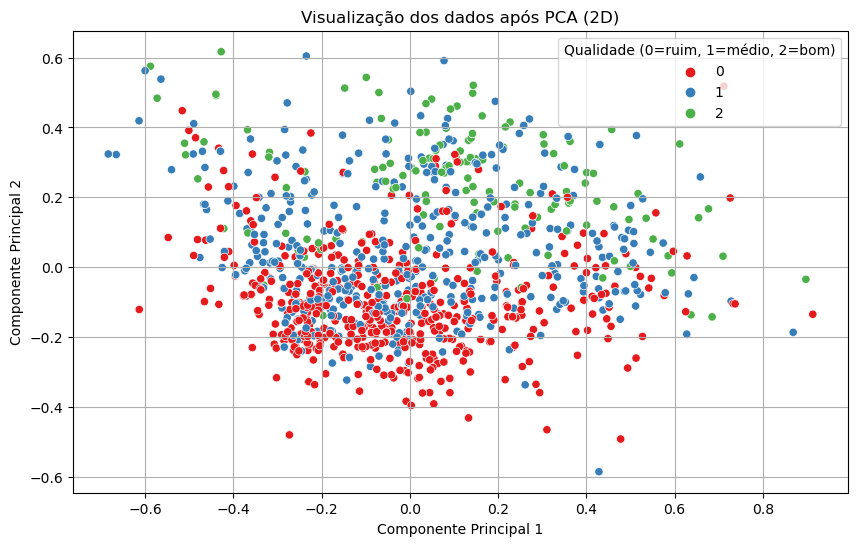

In [17]:
# Identificar colunas numéricas (excluindo a target)
feature_cols = df.drop(columns=["quality", "quality_label"]).columns

# Normalização das features
feature_cols = df.drop(columns=["quality", "quality_label"]).columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

# PCA para redução para 2 dimensões
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled[feature_cols])

# DataFrame com os componentes principais
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['quality_label'] = df_scaled['quality_label']

# Gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='quality_label', palette="Set1")
plt.title("Visualização dos dados após PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title='Qualidade (0=ruim, 1=médio, 2=bom)')
plt.grid(True)
plt.show()